1. Importacion de Librerias

In [29]:
import json
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

2. Carga y Extraccion de datos desde JSON

In [30]:
with open('datos/stations.json', 'r') as file:
    data = json.load(file)

features = []  # Lista para las características de entrada
target = []    # Lista para el valor objetivo (bikesAvailable)

# Extraer características relevantes para cada estación
for station in data['features']:
    props = station['properties']
    try:
        bikes_available = props['bikesAvailable']
        docks_available = props['docksAvailable']
        total_docks = props['totalDocks']
        latitude = props['latitude']
        longitude = props['longitude']

        if None not in (bikes_available, docks_available, total_docks, latitude, longitude):
            features.append([docks_available, total_docks, latitude, longitude])
            target.append(bikes_available)
    except KeyError:
        continue

3. Normalizar y dividir datos

In [31]:
X = np.array(features)
y = np.array(target).reshape(-1, 1)

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)


4. Definicion y compliacion del modelo MLP

In [32]:
neurons = 64
dropout_rate = 0.2
learning_rate = 0.001
regularization = 0.001

modelo_mlp = Sequential()

# Primera capa con normalización por lotes
modelo_mlp.add(Dense(neurons, input_dim=X_train.shape[1], kernel_regularizer=l2(regularization)))
modelo_mlp.add(BatchNormalization())
modelo_mlp.add(Activation('relu'))
modelo_mlp.add(Dropout(dropout_rate))

# Segunda capa oculta
modelo_mlp.add(Dense(neurons, kernel_regularizer=l2(regularization)))
modelo_mlp.add(BatchNormalization())
modelo_mlp.add(Activation('relu'))
modelo_mlp.add(Dropout(dropout_rate))

# Capa de salida
modelo_mlp.add(Dense(1))

# Compilar el modelo
modelo_mlp.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

# Resumen de la arquitectura del modelo
modelo_mlp.summary()

c:\Users\Hola\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,057 (19.75 KB)

 Trainable params: 4,801 (18.75 KB)

 Non-trainable params: 256 (1.00 KB)

Definimos una red neuronal con:

Dos capas ocultas de 64 neuronas

Función de activación ReLU

Optimización con Adam

Pérdida basada en MSE

5. Definicion de callbacks

In [33]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'mejor_modelo_mlp.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


6. Entrenamiento del modelo

In [34]:
history_mlp = modelo_mlp.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 1.8335
Epoch 1: val_loss improved from inf to 1.10636, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 1.5694 - val_loss: 1.1064
Epoch 2/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.5478
Epoch 2: val_loss improved from 1.10636 to 0.96488, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8168 - val_loss: 0.9649
Epoch 3/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5253
Epoch 3: val_loss improved from 0.96488 to 0.87746, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6016 - val_loss: 0.8775
Epoch 4/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.7516
Epoch 4: val_loss improved from 0.87746 to 0.84865, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6704 - val_loss: 0.8487
Epoch 5/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.8194
Epoch 5: val_loss improved from 0.84865 to 0.83683, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6782 - val_loss: 0.8368
Epoch 6/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5600
Epoch 6: val_loss did not improve from 0.83683
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5818 - val_loss: 0.8616
Epoch 7/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6915
Epoch 7: val_loss did not improve from 0.83683
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5821 - val_loss: 0.8771
Epoch 8/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4210
Epoch 8: val_loss did not improve from 0.83683
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4388 - val_loss: 0.8836
Epoch 9/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4561
Epoch 9: val_loss did not improve from 0.83683
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4548 - val_loss: 0.8536
Epoch 10/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3938
Epoch 10: val_loss improved from 0.83683 to 0.83472, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4423 - val_loss: 0.8347
Epoch 11/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3379
Epoch 11: val_loss improved from 0.83472 to 0.79960, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4122 - val_loss: 0.7996
Epoch 12/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.4121
Epoch 12: val_loss improved from 0.79960 to 0.79014, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3946 - val_loss: 0.7901
Epoch 13/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4449 
Epoch 13: val_loss improved from 0.79014 to 0.78123, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.4461 - val_loss: 0.7812
Epoch 14/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.3114
Epoch 14: val_loss improved from 0.78123 to 0.76160, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4527 - val_loss: 0.7616
Epoch 15/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3085
Epoch 15: val_loss improved from 0.76160 to 0.74320, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3730 - val_loss: 0.7432
Epoch 16/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5149
Epoch 16: val_loss improved from 0.74320 to 0.71391, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4462 - val_loss: 0.7139
Epoch 17/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3233
Epoch 17: val_loss improved from 0.71391 to 0.70335, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3302 - val_loss: 0.7034
Epoch 18/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3248
Epoch 18: val_loss improved from 0.70335 to 0.67230, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3211 - val_loss: 0.6723
Epoch 19/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3956
Epoch 19: val_loss improved from 0.67230 to 0.65020, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3889 - val_loss: 0.6502
Epoch 20/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3535
Epoch 20: val_loss improved from 0.65020 to 0.62199, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3098 - val_loss: 0.6220
Epoch 21/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3948
Epoch 21: val_loss improved from 0.62199 to 0.61079, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3815 - val_loss: 0.6108
Epoch 22/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3089
Epoch 22: val_loss improved from 0.61079 to 0.60617, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3440 - val_loss: 0.6062
Epoch 23/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4269
Epoch 23: val_loss improved from 0.60617 to 0.57004, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3480 - val_loss: 0.5700
Epoch 24/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3772
Epoch 24: val_loss improved from 0.57004 to 0.55865, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3589 - val_loss: 0.5586
Epoch 25/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3157
Epoch 25: val_loss improved from 0.55865 to 0.53755, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3358 - val_loss: 0.5375
Epoch 26/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3173
Epoch 26: val_loss improved from 0.53755 to 0.50413, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3142 - val_loss: 0.5041
Epoch 27/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2117
Epoch 27: val_loss improved from 0.50413 to 0.48068, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2589 - val_loss: 0.4807
Epoch 28/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3855
Epoch 28: val_loss improved from 0.48068 to 0.44481, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3387 - val_loss: 0.4448
Epoch 29/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2022
Epoch 29: val_loss improved from 0.44481 to 0.42645, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2483 - val_loss: 0.4265
Epoch 30/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3571
Epoch 30: val_loss improved from 0.42645 to 0.40591, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3668 - val_loss: 0.4059
Epoch 31/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2837
Epoch 31: val_loss improved from 0.40591 to 0.39649, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2898 - val_loss: 0.3965
Epoch 32/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.3643
Epoch 32: val_loss did not improve from 0.39649
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2848 - val_loss: 0.4012
Epoch 33/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3271
Epoch 33: val_loss did not improve from 0.39649
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3461 - val_loss: 0.4022
Epoch 34/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.4258
Epoch 34: val_loss did not improve from 0.39649
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3076 - val_loss: 0.4032
Epoch 35/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1852
Epoch 35: val_loss did not improve from 0.39649
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2428 - val_loss: 0.3996
Epoch 36/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3684
Epoch 36: val_loss improved from 0.39649 to 0.38909, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3083 - val_loss: 0.3891
Epoch 37/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2850
Epoch 37: val_loss improved from 0.38909 to 0.38387, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2809 - val_loss: 0.3839
Epoch 38/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2126
Epoch 38: val_loss improved from 0.38387 to 0.36551, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2941 - val_loss: 0.3655
Epoch 39/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2394
Epoch 39: val_loss improved from 0.36551 to 0.33734, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2575 - val_loss: 0.3373
Epoch 40/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2150
Epoch 40: val_loss improved from 0.33734 to 0.31102, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2665 - val_loss: 0.3110
Epoch 41/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2643
Epoch 41: val_loss improved from 0.31102 to 0.30682, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2956 - val_loss: 0.3068
Epoch 42/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3345
Epoch 42: val_loss improved from 0.30682 to 0.29624, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3164 - val_loss: 0.2962
Epoch 43/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2581
Epoch 43: val_loss improved from 0.29624 to 0.27072, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3097 - val_loss: 0.2707
Epoch 44/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.2698
Epoch 44: val_loss improved from 0.27072 to 0.26782, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3084 - val_loss: 0.2678
Epoch 45/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2191
Epoch 45: val_loss improved from 0.26782 to 0.25716, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2452 - val_loss: 0.2572
Epoch 46/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2906
Epoch 46: val_loss improved from 0.25716 to 0.25368, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2661 - val_loss: 0.2537
Epoch 47/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2061
Epoch 47: val_loss improved from 0.25368 to 0.23853, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2392 - val_loss: 0.2385
Epoch 48/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2335
Epoch 48: val_loss did not improve from 0.23853
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2749 - val_loss: 0.2405
Epoch 49/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3206
Epoch 49: val_loss did not improve from 0.23853
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3064 - val_loss: 0.2585
Epoch 50/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1772
Epoch 50: val_loss did not improve from 0.23853
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2059 - val_loss: 0.2603
Epoch 51/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1961
Epoch 51: val_loss did not improve from 0.23853
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2429 - val_loss: 0.2406
Epoch 52/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2142
Epoch 52: val_loss improved from 0.23853 to 0.22934, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2576 - val_loss: 0.2293
Epoch 53/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2314
Epoch 53: val_loss did not improve from 0.22934
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2157 - val_loss: 0.2314
Epoch 54/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2252
Epoch 54: val_loss improved from 0.22934 to 0.22040, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2244 - val_loss: 0.2204
Epoch 55/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1890
Epoch 55: val_loss improved from 0.22040 to 0.19523, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2012 - val_loss: 0.1952
Epoch 56/150
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2041
Epoch 56: val_loss improved from 0.19523 to 0.18436, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2092 - val_loss: 0.1844
Epoch 57/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2170
Epoch 57: val_loss did not improve from 0.18436
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2261 - val_loss: 0.1847
Epoch 58/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2762
Epoch 58: val_loss improved from 0.18436 to 0.18404, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2630 - val_loss: 0.1840
Epoch 59/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2316
Epoch 59: val_loss did not improve from 0.18404
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2276 - val_loss: 0.1942
Epoch 60/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2482
Epoch 60: val_loss improved from 0.18404 to 0.18006, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2484 - val_loss: 0.1801
Epoch 61/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2551
Epoch 61: val_loss improved from 0.18006 to 0.16598, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2520 - val_loss: 0.1660
Epoch 62/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1625
Epoch 62: val_loss improved from 0.16598 to 0.15322, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2379 - val_loss: 0.1532
Epoch 63/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2211
Epoch 63: val_loss did not improve from 0.15322
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2560 - val_loss: 0.1622
Epoch 64/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1672
Epoch 64: val_loss did not improve from 0.15322
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2006 - val_loss: 0.1655
Epoch 65/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2539
Epoch 65: val_loss did not improve from 0.15322
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2453 - val_loss: 0.1704
Epoch 66/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1971
Epoch 66: val_loss did not improve from 0.15322
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1956 - val_loss: 0.1804
Epoch 67/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2352
Epoch 67: val_loss did not improve from 0.15322
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2510 - val_loss: 0.172

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2160 - val_loss: 0.1463
Epoch 70/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2418
Epoch 70: val_loss improved from 0.14627 to 0.13858, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2502 - val_loss: 0.1386
Epoch 71/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.4412
Epoch 71: val_loss did not improve from 0.13858
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3116 - val_loss: 0.1420
Epoch 72/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1540
Epoch 72: val_loss did not improve from 0.13858
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1939 - val_loss: 0.1507
Epoch 73/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.4189
Epoch 73: val_loss did not improve from 0.13858
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3040 - val_loss: 0.1588
Epoch 74/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2240
Epoch 74: val_loss did not improve from 0.13858
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2087 - val_loss: 0.1625
Epoch 75/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2182
Epoch 75: val_loss did not improve from 0.13858
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2549 - val_loss: 0.154

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1834 - val_loss: 0.1301
Epoch 84/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1805
Epoch 84: val_loss did not improve from 0.13006
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1895 - val_loss: 0.1319
Epoch 85/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1535
Epoch 85: val_loss did not improve from 0.13006
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1734 - val_loss: 0.1313
Epoch 86/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2812
Epoch 86: val_loss did not improve from 0.13006
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2243 - val_loss: 0.1309
Epoch 87/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2732
Epoch 87: val_loss improved from 0.13006 to 0.12980, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2245 - val_loss: 0.1298
Epoch 88/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1667
Epoch 88: val_loss did not improve from 0.12980
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2313 - val_loss: 0.1367
Epoch 89/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1791
Epoch 89: val_loss did not improve from 0.12980
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1881 - val_loss: 0.1365
Epoch 90/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2064
Epoch 90: val_loss did not improve from 0.12980
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1759 - val_loss: 0.1353
Epoch 91/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2268
Epoch 91: val_loss did not improve from 0.12980
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2100 - val_loss: 0.1318
Epoch 92/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1907
Epoch 92: val_loss did not improve from 0.12980
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1599 - val_loss: 0.130

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1823 - val_loss: 0.1286
Epoch 94/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.2117
Epoch 94: val_loss improved from 0.12859 to 0.12431, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2212 - val_loss: 0.1243
Epoch 95/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2082
Epoch 95: val_loss improved from 0.12431 to 0.12207, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1933 - val_loss: 0.1221
Epoch 96/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1698
Epoch 96: val_loss improved from 0.12207 to 0.11937, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1765 - val_loss: 0.1194
Epoch 97/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1583
Epoch 97: val_loss improved from 0.11937 to 0.11848, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1591 - val_loss: 0.1185
Epoch 98/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1413
Epoch 98: val_loss improved from 0.11848 to 0.11836, saving model to mejor_modelo_mlp.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1730 - val_loss: 0.1184
Epoch 99/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1539
Epoch 99: val_loss did not improve from 0.11836
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1814 - val_loss: 0.1220
Epoch 100/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2691
Epoch 100: val_loss did not improve from 0.11836
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2030 - val_loss: 0.1240
Epoch 101/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1154
Epoch 101: val_loss did not improve from 0.11836
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1419 - val_loss: 0.1246
Epoch 102/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1245
Epoch 102: val_loss did not improve from 0.11836
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1554 - val_loss: 0.1201
Epoch 103/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1641
Epoch 103: val_loss did not improve from 0.11836
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1904 - val_los

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1873 - val_loss: 0.1179
Epoch 110/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2852
Epoch 110: val_loss did not improve from 0.11788
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2099 - val_loss: 0.1192
Epoch 111/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1564
Epoch 111: val_loss did not improve from 0.11788
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1605 - val_loss: 0.1179
Epoch 112/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1889
Epoch 112: val_loss did not improve from 0.11788
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1705 - val_loss: 0.1217
Epoch 113/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2215
Epoch 113: val_loss did not improve from 0.11788
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2444 - val_loss: 0.1292
Epoch 114/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1928
Epoch 114: val_loss did not improve from 0.11788
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1809 - val_l

7. Evaluacion del modelo

In [35]:
y_pred_mlp = modelo_mlp.predict(X_test)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print("\n--- Resultados Red Neuronal MLP Mejorada ---")
print(f"Error cuadrático medio (MSE): {mse_mlp:.4f}")
print(f"Coeficiente de determinación (R2): {r2_mlp:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

--- Resultados Red Neuronal MLP Mejorada ---
Error cuadrático medio (MSE): 0.0566
Coeficiente de determinación (R2): 0.9535


8. Mostrar resultados reales vs predichos

In [36]:
y_test_real_mlp = scaler_y.inverse_transform(y_test)
y_pred_real_mlp = scaler_y.inverse_transform(y_pred_mlp)

print("\nEjemplos de predicción (MLP):")
for i in range(10):
    print(f"Real: {y_test_real_mlp[i][0]:.2f} - Predicción: {y_pred_real_mlp[i][0]:.2f}")


Ejemplos de predicción (MLP):
Real: 14.00 - Predicción: 13.34
Real: 5.00 - Predicción: 4.30
Real: 2.00 - Predicción: 5.50
Real: 2.00 - Predicción: 4.61
Real: 33.00 - Predicción: 32.84
Real: 1.00 - Predicción: 1.21
Real: 3.00 - Predicción: 2.68
Real: 5.00 - Predicción: 6.20
Real: 9.00 - Predicción: 8.61
Real: 9.00 - Predicción: 8.23


9. Visualizacion de resultados

9.1 Grafico curva de aprendizaje

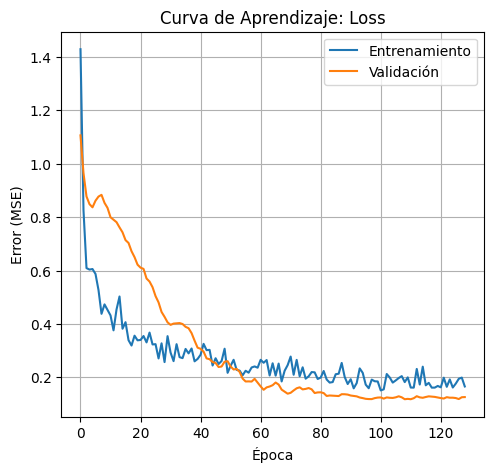

In [37]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_mlp.history['loss'], label='Entrenamiento')
plt.plot(history_mlp.history['val_loss'], label='Validación')
plt.title('Curva de Aprendizaje: Loss')
plt.xlabel('Época')
plt.ylabel('Error (MSE)')
plt.legend()
plt.grid(True)

9.2 Grafico comparativo de predicciones

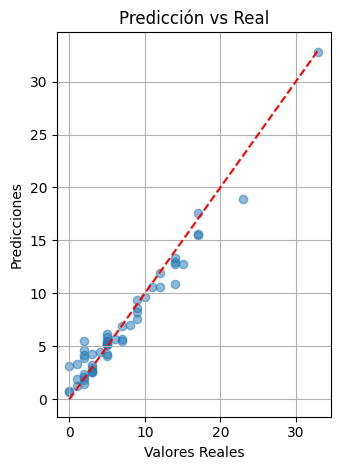

In [38]:
plt.subplot(1, 2, 2)
plt.scatter(y_test_real_mlp, y_pred_real_mlp, alpha=0.5)
plt.plot([min(y_test_real_mlp), max(y_test_real_mlp)], 
         [min(y_test_real_mlp), max(y_test_real_mlp)], 
         'r--')
plt.title('Predicción vs Real')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.grid(True)
plt.tight_layout()
plt.show()

9.3 Grafico de comparacion de valores reales vs predichos (por muestra)

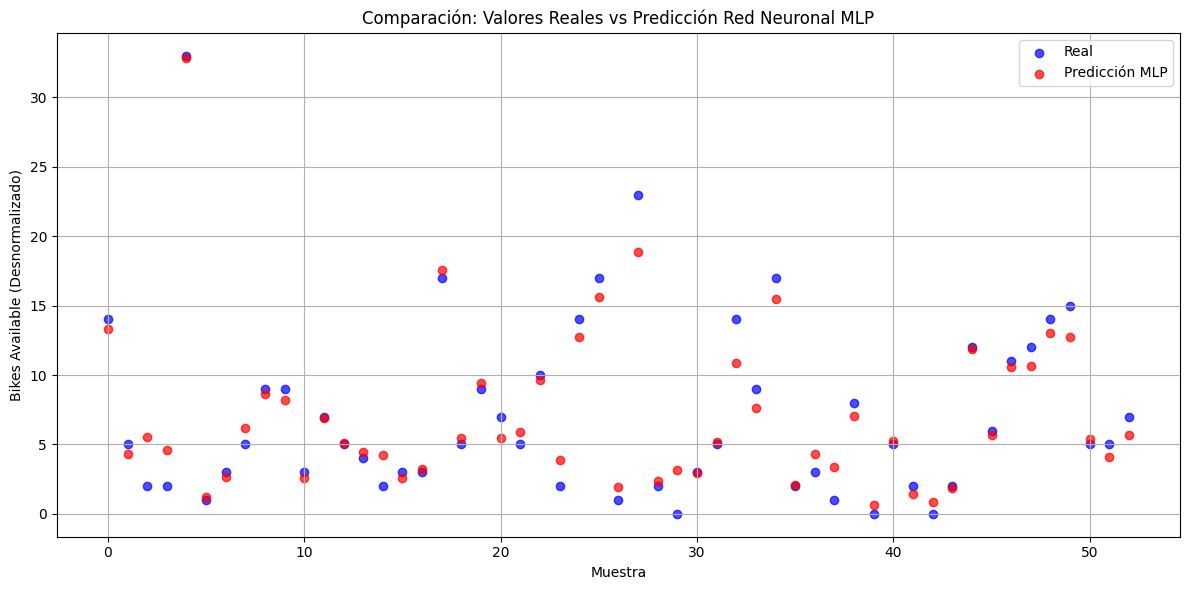

In [39]:
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test_real_mlp)), y_test_real_mlp, label='Real', color='blue', alpha=0.7)
plt.scatter(range(len(y_pred_real_mlp)), y_pred_real_mlp, label='Predicción MLP', color='red', alpha=0.7)
plt.title('Comparación: Valores Reales vs Predicción Red Neuronal MLP')
plt.xlabel('Muestra')
plt.ylabel('Bikes Available (Desnormalizado)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

9.4 Visualizacion de residuos

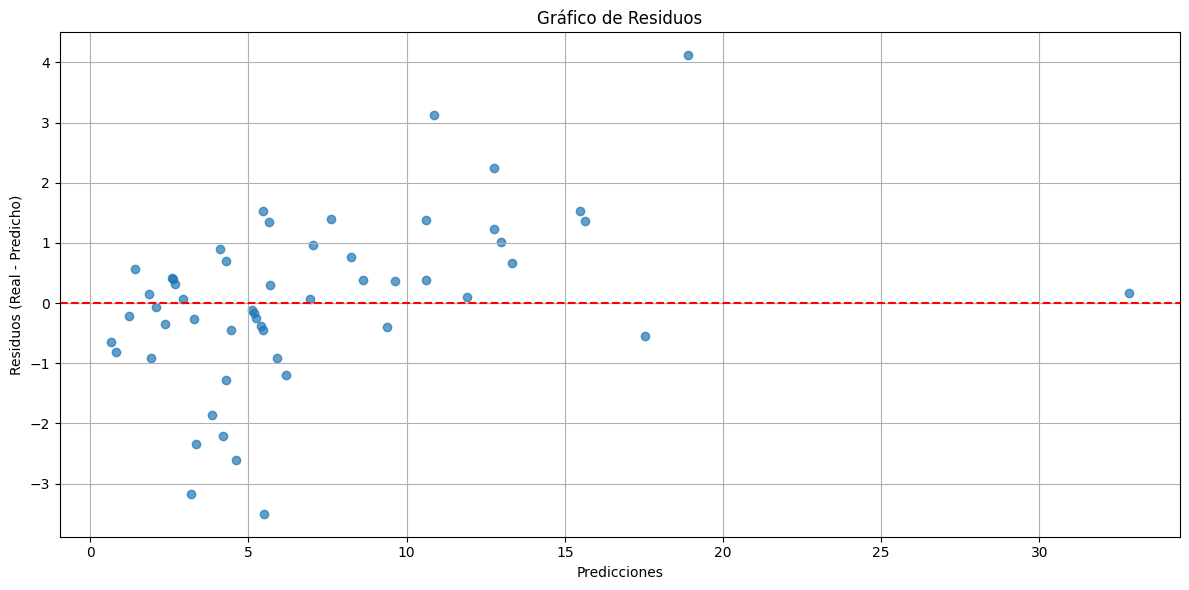

In [40]:
residuos = y_test_real_mlp - y_pred_real_mlp
plt.figure(figsize=(12, 6))
plt.scatter(y_pred_real_mlp, residuos, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Gráfico de Residuos')
plt.xlabel('Predicciones')
plt.ylabel('Residuos (Real - Predicho)')
plt.grid(True)
plt.tight_layout()
plt.show()

10. Prediccion de una nueva estacion

In [41]:
nueva_muestra = np.array([[10, 15, 39.9522, -75.1639]])  # docksAvailable, totalDocks, lat, lon
nueva_muestra_norm = scaler_X.transform(nueva_muestra)

prediccion_norm_mlp = modelo_mlp.predict(nueva_muestra_norm)
prediccion_final_mlp = scaler_y.inverse_transform(prediccion_norm_mlp)

print(f"\nPredicción para estación con 10 docks disponibles, 15 en total y coordenadas (lat, lon) (MLP): {prediccion_final_mlp[0][0]:.2f} bicicletas disponibles")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Predicción para estación con 10 docks disponibles, 15 en total y coordenadas (lat, lon) (MLP): 4.08 bicicletas disponibles


11. Guardar el modelo entrenado

In [42]:
modelo_mlp.save('modelo_mlp_final_bicicletas.h5')
print("\nModelo guardado como 'modelo_mlp_final_bicicletas.h5'")


Modelo guardado como 'modelo_mlp_final_bicicletas.h5'
